<a href="https://colab.research.google.com/github/Giffy/Mobile_footprint_AIBCN/blob/master/3_Dataset_creation_Images_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset creation (Vehicle density images)

Creation of mobile phone density images of Barcelona

In [0]:
# Load libraries
import pandas as pd
import seaborn
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

##  Download mobile phone cleansed data

In [0]:
# Download previously cleansed data from 'Github'
!pip install wget > /dev/null
import wget
url = 'https://raw.githubusercontent.com/Giffy/Mobile_footprint_AIBCN/master/dataset/coverageCatHDv6.tar.gz'
try:
  filename = wget.download(url)
  print ( 'Dataset downloaded successfully.')

  # Extract tar file
  import tarfile
  tf = tarfile.open( filename )
  tf.extractall()
  
except:
  print ( 'Error downloading dataset.')


Dataset downloaded successfully.


##  Load data

In [0]:
# load data
df = pd.read_csv('coverageCat.csv')
df.head(3)

,Activitat,Day,Hour,Latitude,Longitude,Month,Weekday,Year
0,UNKNOWN,17,1,41.3875,2.1980,10,6,2015
1,IN_VEHICLE,17,1,41.3860,2.1395,10,6,2015
2,IN_VEHICLE,17,1,41.3860,2.1395,10,6,2015


In [0]:
df.tail(3)

,Activitat,Day,Hour,Latitude,Longitude,Month,Weekday,Year
2879093,IN_VEHICLE,4,0,41.455,2.03,1,3,2017
2879094,IN_VEHICLE,4,0,41.455,2.03,5,4,2017
2879095,IN_VEHICLE,19,0,41.455,2.03,10,3,2016


##  Data cleansing

In [0]:
df = df[df['Activitat']=='IN_VEHICLE']                                    # Keeps in dataFrame the data with activity "IN VEHICLE"

weekdays = [1,2,3,4,5]
df = df[(df['Weekday'].isin(weekdays))]                                   # Keeps in dataFrame the data from Monday to Friday

##  Generate dataset graphics
Using seaborn to generate graphics of mobile phone density

![Density_sample](https://raw.githubusercontent.com/Giffy/Mobility_AIBCN/master/dataset/plt_sample.png)



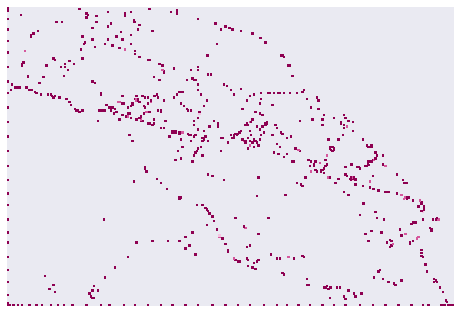

In [0]:
# Test of plotting graphic with seaborn
df0 = df[ (df['Year']== 2015) & (df['Month']== 5) & (df['Day']== 1)]
df0 = df0.groupby(['Latitude','Longitude'], as_index= False).count()
result = df0.pivot (index='Latitude' , columns='Longitude', values='Day')


sns_plot = seaborn.heatmap(result, 
                           cbar= False,                            # Removes color bar with scale 
                           xticklabels=False,                      # Removes X-axis labels
                           yticklabels=False,                      # Removes Y-axis labels
                           cmap="PiYG",                            # 2 contrasting colors
                           center=4
                          ) 

sns_plot.set_xlabel('')                                            # Removes X-axis title
sns_plot.set_ylabel('')                                            # Removes Y-axis title

fig = sns_plot.get_figure()                                        # Generates the heatmap image
fig.savefig("output.png")                                          # Saves the image as png

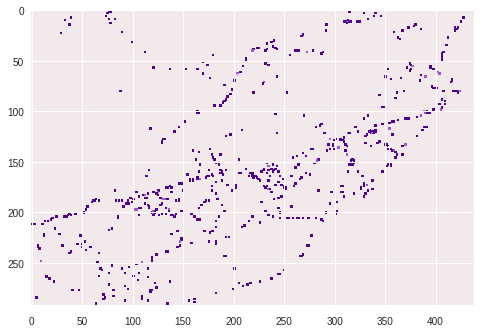

In [0]:
# Test Image Crop and Flip 
img = cv2.imread("output.png")
crop_img = img[44:340, 80:518]
flip_img = cv2.flip( crop_img, 0)
plt.imshow(flip_img, cmap="gray")
plt.show()

In [0]:
!mkdir /content/Images
path = '/content/Images/'                                                # Path to store the heatmap images generated

# List of years, months, days and weekdays
years = [2015, 2016, 2017]
months = [1,2,3,4,5,6,7,8,9,10,11,12]
days = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]


def generate_images ( hours, middle_color, filename_desc ):
  
  count = 0
  df0 = df[(df['Hour'].isin(hours))]                                      # Creates a dataset within the time range selected
  for year in years:                                                      # Iteration to collect the data per each picture
    df1 = df0[(df0['Year']== year)]                                       # Selects a year from list
    for month in months:
      df2 = df1[(df1['Month']== month)]                                   # Selects a month from list
      print ("Progress: " + str(year) + '_' + str(month))
      for day in days:
        df3 = df2[(df2['Day']== day)]                                     # Selects a day from list
        df4 = df3.groupby(['Latitude','Longitude'], as_index= False).count()
        result = df4.pivot (index='Latitude' , columns='Longitude', values='Day')        
        
        try:                                                              # Try to catch the error when seaborn crashes, when result is empty (weekends, some days for months shorter than 31 days)
          sns_plot = seaborn.heatmap(result, 
                                     cbar= False,                         # Removes color bar with scale 
                                     xticklabels=False,                   # Removes X-axis labels
                                     yticklabels=False,                   # Removes Y-axis labels
                                     cmap="PiYG",                         # 2 contrasting colors
                                     center= middle_color                 # Defines middle color
                                    ) 
          sns_plot.set_xlabel('')                                         # Removes X-axis title
          sns_plot.set_ylabel('')                                         # Removes Y-axis title
          
          fig = sns_plot.get_figure()                                     # Plots the heatmap image

          # Filename creation
          period = filename_desc
          filename = str(year) + '_' + str(month) + '_' + str(day) + '_' + period + '.png' 

          fig.savefig( path + filename )                                  # Saves image as png
          fig.clf()                                                       # Cleans figure content
          sns_plot = None
          
          img = cv2.imread(path + filename)
          crop_img = img[44:340, 80:518]                                  # Crop image to remove outer white square 
          flip_img = cv2.flip( crop_img, 0)                               # Vertical flip
          cv2.imwrite (path + filename , flip_img)
          
          count +=1
        except:
          pass
  print ( "Created " + str(count) + " images")

mkdir: cannot create directory ‘/content/Images’: File exists


In [0]:
!rm /content/Images/*.png

## Data creation and augmentation

In [0]:
fd_even = [0,2,4,6,8,10,12,14,16,18,20,22,24]  # 0 includes outer frame to keep image size constant
fd_odd  = [0,1,3,5,7,9,11,13,15,17,19,21,23]   # 0 includes outer frame to keep image size constant
am      = [0,5,6,7,8,9,10,11]                     # 0 includes outer frame to keep image size constant
pm      = [0,16,17,18,19,20,21]                # 0 includes outer frame to keep image size constant
a2      = [0,7,8,9]            
a3      = [0,8,9,10] 
a4      = [0,9,10,11]
a5      = [0,16,17,18]
a6      = [0,17,18,19]
a7      = [0,18,19,20]


timing = []
timing.append(fd_even)
timing.append(fd_odd)
timing.append(am)
timing.append(pm)
timing.append(a2)
timing.append(a3)
timing.append(a4)
timing.append(a5)
timing.append(a6)
timing.append(a7)

In [0]:
name = 1
for time in timing:
  print ('----- > Loop '+ str(name))
  if len(time) > 7:
    middle_color = 4
  else:
    middle_color = 3
  generate_images ( time, middle_color, filename_desc= str(name) )
  name += 1

## Deleting images with low volume data

In [0]:
!rm Images/2015_1_*
!rm Images/2015_2_*
!rm Images/2015_3_2_*
!rm Images/2015_3_3_*
!rm Images/2015_3_4_*
!rm Images/2015_5_1_*
!rm Images/2015_9_11_*
!rm Images/2015_10_12_*
!rm Images/2015_12_25_*

!rm Images/2016_4_4_*
!rm Images/2016_4_6_*
!rm Images/2016_4_7_*
!rm Images/2016_4_8_*
!rm Images/2016_10_4_*
!rm Images/2016_10_10_*
!rm Images/2016_10_18_*
!rm Images/2016_10_19_*
!rm Images/2016_11_4_*
!rm Images/2016_12_26_*

!rm Images/2017_1_4_*
!rm Images/2017_7_4_*
!rm Images/2017_4_4_*
!rm Images/2017_4_14_*
!rm Images/2017_5_4_*
!rm Images/2017_12_7_*
!rm Images/2017_12_25_*
!rm Images/2017_12_26_*
!rm Images/2017_12_29_*

## Copy dataset to Google Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')                                                   # Mounts Google Drive as a folder in google Colab

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!tar -czvf images_v2.tar.gz Images > /dev/null
!mv images_v2.tar.gz /gdrive/My\ Drive/

## Plotting data sample with Folium

In [0]:
!pip install folium geopandas  > /dev/null   # Install folium for map visualization

import folium                             # Library to create the map
from folium import plugins                # plugin to create a heatmap

In [0]:
df0 = df[ (df['Year']== 2015) & (df['Month']== 2) & (df['Day']== 6)]
df0 = df0.groupby(['Latitude','Longitude'], as_index= False).count()           

latitude = df0.loc [ : , 'Latitude']
longitude = df0.loc [ : , 'Longitude']
total = df0.loc [ : , 'Day']

In [0]:
center_lat = 41.391
center_lon = 2.137

locationmap = folium.Map(location=[ center_lat , center_lon ], zoom_start=12, width=800, height=600 )
locationmap.add_child(plugins.HeatMap(zip(latitude, longitude, total), radius = 12))

locationmap